In [2]:
using LinearAlgebra
using PyPlot
using Statistics

In [240]:
function hamiltonian(N_third, V0=0, Vr=0)
    """Returns an hamiltonian for a well with 3N_third points, with a central
    barrier of V0 and the right well perturbed by Vr
         V0
       |----| Vr
    ---|    |----"""
    
    N = 3*N_third
    dx = 1/(N-1)
    
    # Approximate double derivative with central finite difference
    # The endpoints are always zero, because V=infty outside the well, so only include N-2 points
    diagonal = fill(2.0/dx^2, N-2)
    diagonal[N_third:2*N_third-1] .+= V0
    diagonal[2*N_third:end] .+= Vr
    subdiagonal = fill(-1.0/dx^2, N-3)
    H = SymTridiagonal(diagonal, subdiagonal)
    return H
end


function solve_eigenvalues(N_third, V0=0, Vr=0)
    H = hamiltonian(N_third, V0, Vr)
    return eigvals(H)
end


function solve_eigenproblem(N_third, V0=0, Vr=0)
    N = 3*N_third
    H = hamiltonian(N_third, V0, Vr)
    dx = 1/(3*N_third-1)
    
    # Since we want to fill in end points, which are
    # excluded in the hamiltonian, we cannot
    # simply return the output from eigen
    vectors = Array{Float64, 2}(undef, N, N-2)
    values, vectors[2:end-1, :] = eigen(H)
    vectors ./= sqrt(dx)  # Normalize the solutions
    vectors[[1,end], :] .= 0
    
    return values, vectors
end


function plot_functions(values, vectors, irange; V0=0, Vr=0, legend=false, scale=0)
    """Plots the vectors given by irange"""
    
    N, num = size(vectors)
    x = range(0, 1, length=N)
    
    # Find an appropriate scaling of the wave, to make it visible
    if scale==0
        biggest_energy = maximum(values[irange])
        smallest_energy = minimum(values[irange])
        delta_energy = biggest_energy - smallest_energy
        biggest_wave = maximum(abs.(vectors[:, irange]))
        scale = delta_energy / (5 * biggest_wave)  # Make biggest wave 1/5 of the energy gap
        scale = max(scale, 1)
    end
    
    # Potential
    plt.plot([0, 1/3, 1/3, 2/3, 2/3, 1], [0, 0, V0, V0, Vr, Vr], color="gray", linestyle=":")
    
    # Waves
    for i in irange
        plt.axhline(values[i], linestyle="dashed", color="gray", linewidth=0.5)
        plt.plot(x, values[i] .+ scale*vectors[:, i], label="\$\\psi_$i\$")
    end
    if legend
        plt.legend()
    end
end


function eigenfunction_error(vector::AbstractVector, n::Integer)
    """Finds the sum of squares error in vector"""
    x = range(0, 1, length=length(vector))
    anal = sqrt(2)*sin.(n*pi*x)
    
    # Return the "mean" of square error
    #return sum(abs2, vector-anal)/length(vector)
    error = (vector-anal)./max.(anal, 0.001)
    return mean(abs2, error)
end


function flip(vector::AbstractVector)
    """When comparing analytical and numerical solutions, it is
    important that we have exactly the same function.
    Since the numerical solution can give both +sin and -sin, this
    function ensures to get the +sin"""
    
    return flipsign.(vector, vector[2])
end


function inner_product(psi_1::AbstractVector, psi_2::AbstractVector, dx)
    """Assumes real psi"""
    return sum(psi_1 .* psi_2) * dx
end


function get_coefficients(state, vectors)
    N, n = size(vectors)
    dx = 1/(N-1)
    return [inner_product(vectors[:, i], state, dx) for i in 1:n]
end


function develop_in_time(t, initial_state, vectors, values)
    N, n = size(vectors)
    dx = 1/(N-1)
    
    total = zero(initial_state)
    coefficients = get_coefficients(initial_state, vectors)
    
    for n in eachindex(coefficients)
        total += coefficients[n] * vectors[:, n] * exp(values[n]*t*im)
    end
    return total
end


function crank_nicolson_step(state, H, dt)
    """Solves (1+i/2 dt H)psi(t+dt) = (1 - i/2 dt H) psi(t)"""
    RHS = (I - im*dt/2 * H) * state
    return (I + im*dt/2 *H) \ RHS
end


function eigenvalues_at_zero(lambda, v0)
    """The eigenvalues lamnda < v0 are given by the zeros of this function"""
    k = sqrt(lambda)
    kappa = sqrt(v0 - lambda)
    first_term = exp(kappa/3) * (kappa*sin(k/3) + k*cos(k/3))^2
    second_term = exp(-kappa/3) * (kappa*sin(k/3) - k*cos(k/3))^2
    return first_term - second_term
end


function setup(N_third)
    N = 3*N_third
    dx = 1/(N-1)
    
    return N_third, N, dx
end

setup (generic function with 1 method)

## 2.5

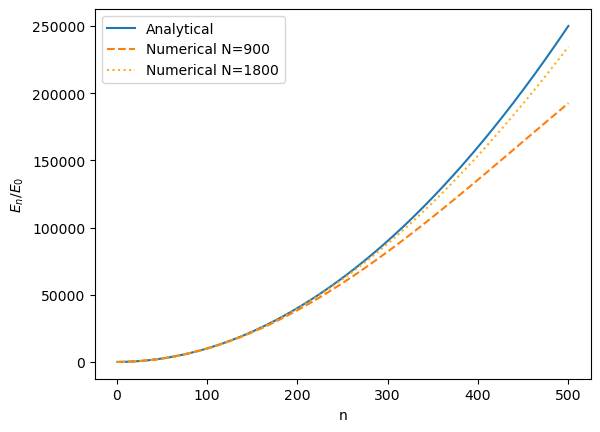

In [21]:
N_third, N, dx = setup(300)
n = 1:500
values, vectors = solve_eigenproblem(N_third)
values_high = solve_eigenvalues(2*N_third)
plt.plot(n, n.^2, label="Analytical")
plt.plot(n, values[n] / pi^2, "--", label="Numerical N=900")
plt.plot(n, values_high[n] / pi^2, ":", alpha=0.9, color="orange", label="Numerical N=1800")
plt.xlabel("n")
plt.ylabel("\$E_n / E_0\$")
plt.legend()

## 2.6 Error in eigenfunctions

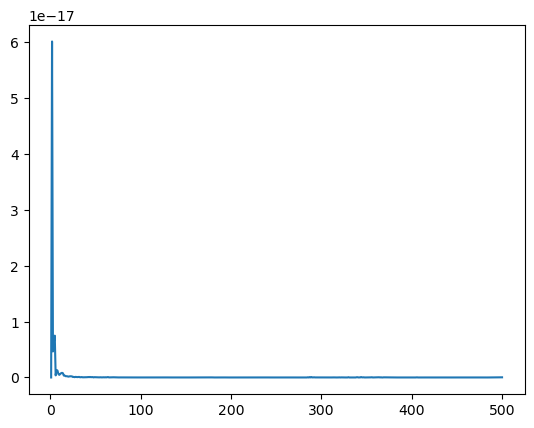

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa618556160>

In [4]:
# Use values from 2.5

# Use flip to ensure +sin( not -sin), so that we can compare to analytical.
errors = [eigenfunction_error(flip(vectors[:, n]), n) for n in n]
plt.plot(n, errors)

## 2.8 and 2.9 - Orthogoality of eigenvetors

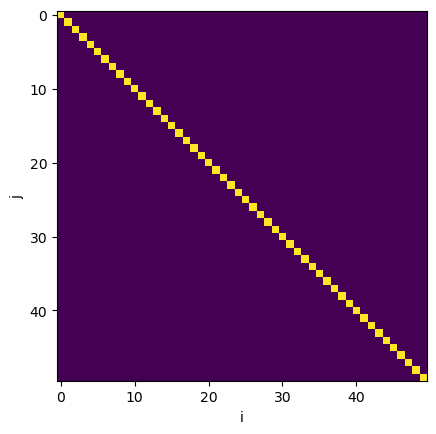

In [27]:
N_third, N, dx = setup(300)
values, vectors = solve_eigenproblem(N_third)

# Calculate the coefficients c_ij = <psi_i, psi_j>
number_to_check = 50
coefficients = Array{Float64, 2}(undef, number_to_check, number_to_check)
for idx in CartesianIndices(coefficients)
    i, j = Tuple(idx)
    coefficients[idx] = inner_product(vectors[:, i], vectors[:, j], dx)
end

plt.imshow(coefficients)
plt.xlabel("i")
plt.ylabel("j")

## 2.10 and 2.11

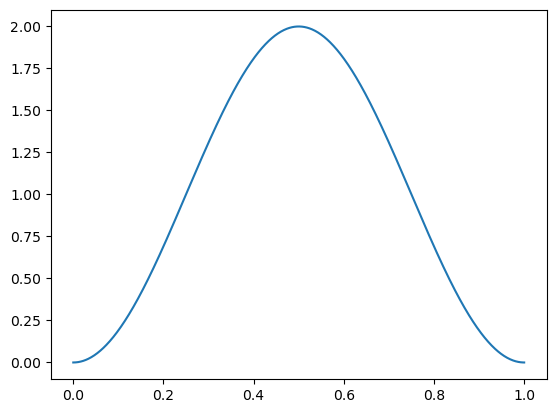

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa63b8bc370>

In [6]:
N_third, N, dx = setup(300)
values, vectors = solve_eigenproblem(N_third)

x = range(0, 1, length=N)
initial_state = sqrt(2) * sinpi.(x)

developed_psi = develop_in_time(0.125, initial_state, vectors, values)
#plt.plot(x, real(developed_psi))
#plt.plot(x, imag(developed_psi))
plt.plot(x, abs2.(developed_psi))

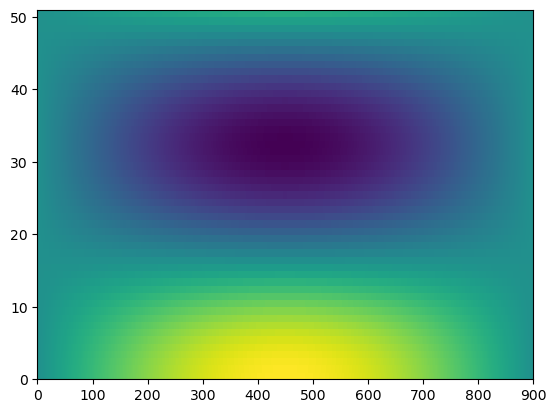

PyObject <matplotlib.collections.QuadMesh object at 0x7fa63b88d910>

In [7]:
t_space = 0:0.01:0.5
psi_t = Array{Complex, 2}(undef, length(t_space), N)
for i in eachindex(t_space)
    psi_t[i, :] = develop_in_time(t_space[i], initial_state, vectors, values)
end
plt.pcolormesh(real(psi_t))

### A delta function

In [172]:
N_third, N, dx = setup(200)
x = 0:dx:1
values, vectors = solve_eigenproblem(N_third)

initial_state = zeros(N)
initial_state[Integer(floor(N/2))] = 1/sqrt(dx)

t_space = 0:0.001:0.5
psi_t = Array{Complex, 2}(undef, length(t_space), N)
for i in eachindex(t_space)
    psi_t[i, :] = develop_in_time(t_space[i], initial_state, vectors[:, 1:25], values[1:25])
end
#plt.pcolormesh(real(psi_t))

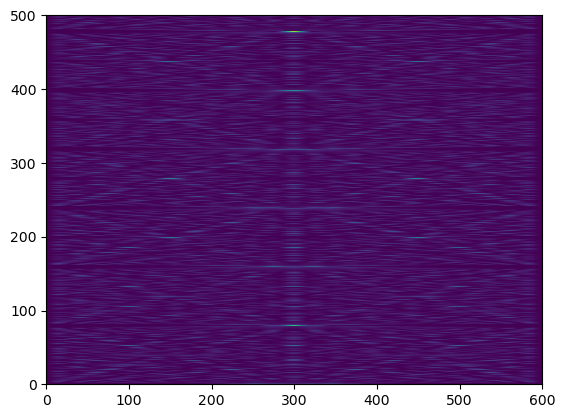

PyObject <matplotlib.collections.QuadMesh object at 0x7feb368b7d90>

In [173]:
plt.pcolormesh(abs2.(psi_t))

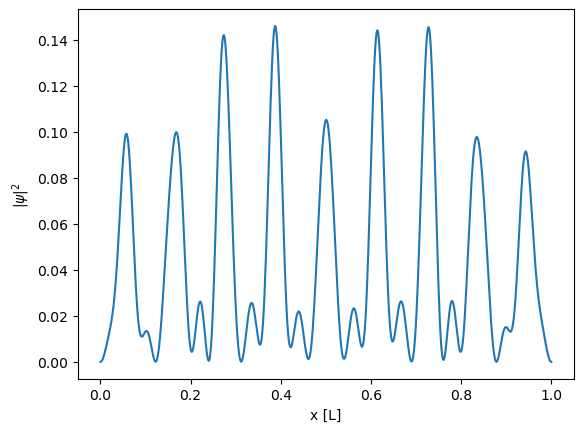

PyObject Text(31.60000000000001, 0.5, '$|\\psi|^2$')

In [174]:
plt.plot(x, abs2.(psi_t[10, :]))
plt.xlabel("x [L]")
plt.ylabel("\$|\\psi|^2\$")

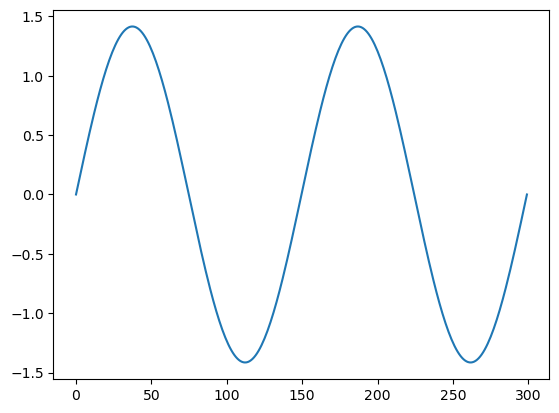

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa6184cb5b0>

In [32]:
plt.plot(vectors[:, 4])

## 3.2 and 3.3 - A high barrier

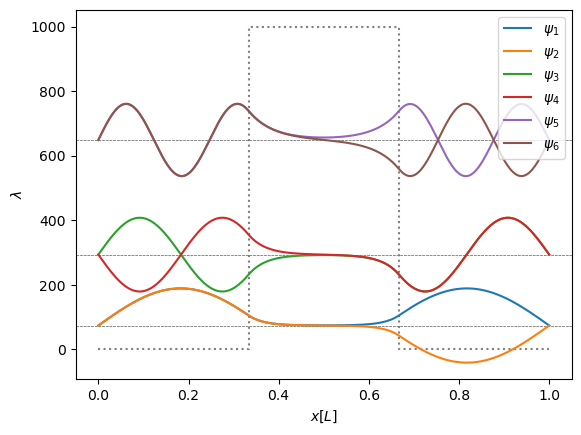

PyObject Text(25.0, 0.5, '$\\lambda$')

In [252]:
N_third, N, dx = setup(600)
x = range(0, 1, length=N)
V0 = 1e3
values, vectors = solve_eigenproblem(N_third, V0, 0)
plot_functions(values, vectors, 1:6, V0=V0, legend=true)
plt.xlabel("\$x [L]\$")
plt.ylabel("\$\\lambda\$")

In [253]:
values[1:6]

6-element Array{Float64,1}:
  73.97242617559621
  73.97435014249754
 293.63539019483073
 293.65919415401424
 648.5636043549779 
 649.0492180378544 

### 3.4 and 3.5

In [254]:
# Theoretical energy splitting
function splitting(lambda, V0)
    return 24*lambda/V0 * sqrt(V0-lambda) * exp(-sqrt(V0-lambda)/3)
end

splitting (generic function with 1 method)

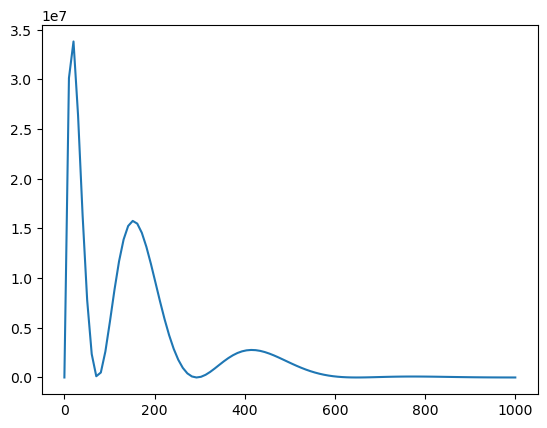

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7feb35b3a520>

In [255]:
V0 = 1e3
lambda = range(0, V0, length=100)
plt.plot(lambda, eigenvalues_at_zero.(lambda, V0))

In [256]:
using Roots
l0, l1, l2, l3, l4, l5, l6 = find_zeros(x -> eigenvalues_at_zero(x, V0), 0, 800)
println(l2-l1)
println(values[2] - values[1])

println(l4-l3)
println(values[4] - values[3])

println(l6-l5)
println(values[6] - values[5])

println(splitting(values[4], V0))

0.0019327586366273408
0.0019239669013302318
0.023883055239423356
0.023803959183510415
0.4859050742636555
0.48561368287653295
0.02661562193400146


In [257]:
println((values[2] - values[1])/values[2])
println((values[4] - values[3])/values[4])
println((values[6] - values[5])/values[6])

2.600856780254338e-5
8.105981238587084e-5
0.0007481923856939468


In [258]:
println((values[2] - values[1]) / (l2 - l1))
println((values[4] - values[3]) / (l4 - l3))
println((values[6] - values[5]) / (l6 - l5))

0.9954511985456961
0.9966881935698755
0.9994003121132988


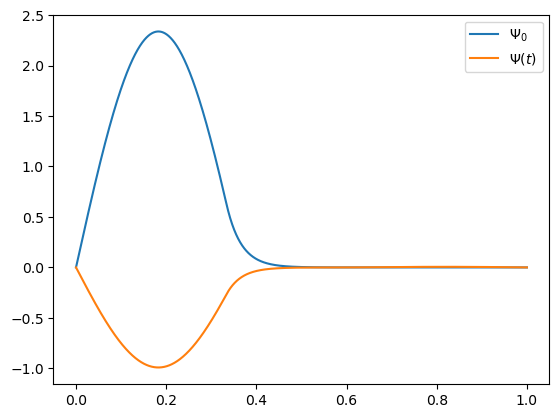

PyObject <matplotlib.legend.Legend object at 0x7feb354f8670>

In [293]:
psi_0 = (vectors[:, 1] + vectors[:, 2])/sqrt(2)
psi_t = develop_in_time(3, psi_0, vectors, values)

plt.plot(x, psi_0, label="\$\\Psi_0\$")
plt.plot(x, psi_t, label="\$\\Psi(t)\$")
plt.legend()

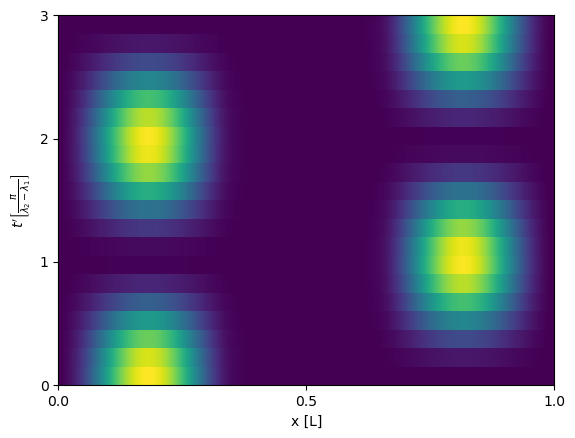

In [304]:
t_space = range(0, 3*pi/(values[2] - values[1]), length=20)
psi = Array{Complex, 2}(undef, length(t_space), N)
for i in eachindex(t_space)
    psi[i, :] = develop_in_time(t_space[i], psi_0, vectors, values)
end

plt.pcolormesh(abs2.(psi))

plt.yticks([0, 6.666, 2*6.66, 20], [0, 1, 2, 3])
plt.xticks([0, N/2, N], [0, 0.5, 1])
plt.xlabel("x [L]")
plt.ylabel("\$ t' \\left[\\frac{\\pi}{\\lambda_2 - \\lambda_1}\\right]\$")

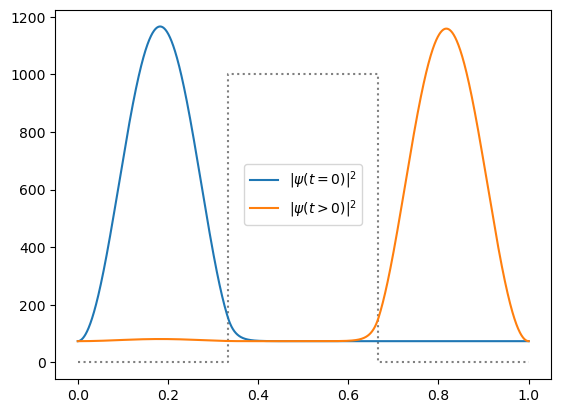

In [289]:
energy = (values[2] + values[1])/2
plt.plot([0,1/3, 1/3, 2/3, 2/3, 1], [0, 0, V0, V0, 0, 0], ":", color="gray")
x = range(0, 1, length=N)
plt.plot(x, energy .+ 200*abs2.(psi[1, :]), label="\$|\\psi(t=0)|^2\$")
plt.plot(x, energy .+ 200*abs2.(psi[7, :]), label="\$|\\psi(t>0)|^2\$") # label="\$\\psi(t=\\frac{\\pi}{\\lambda_2 - \\lambda_1})\$")
plt.legend()

### Forward euler

In [20]:
H = hamiltonian(N_third, V0)
dt = 0.3*dx^2
t_end = 0.001
t_space = 0:dt:t_end

psi = Array{Complex, 2}(undef, length(t_space), N-2)  # N-2 because endpoints are not used with H
psi[1, :] = vectors[2:end-1, 1] 

for i in eachindex(t_space)[2:end]
    psi[i, :] = (I - im*dt*H) * psi[i-1, :]
end

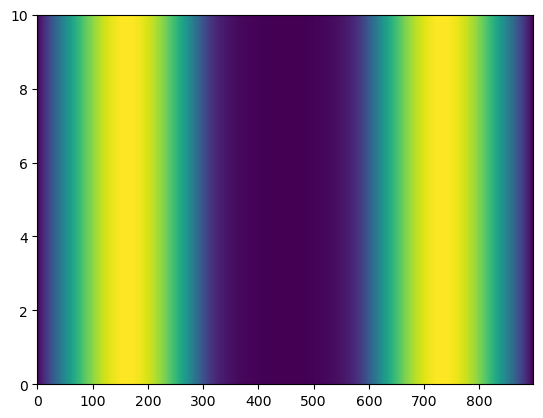

PyObject <matplotlib.collections.QuadMesh object at 0x7fa618cb8d30>

In [21]:
plt.pcolormesh(real(psi[1:10, 1:end]))

## Time evloution usign crank nicolson

In [22]:
H = hamiltonian(N_third, V0)
dt = 1
t_end = 100
t_space = 0:dt:t_end

psi = Array{Complex, 2}(undef, length(t_space), N-2)  # N-2 because endpoints are not used with H
psi[1, :] = vectors[2:end-1, 1] 

for i in eachindex(t_space)[2:end]
    psi[i, :] = crank_nicolson_step(psi[i-1, :], H, dt)
end

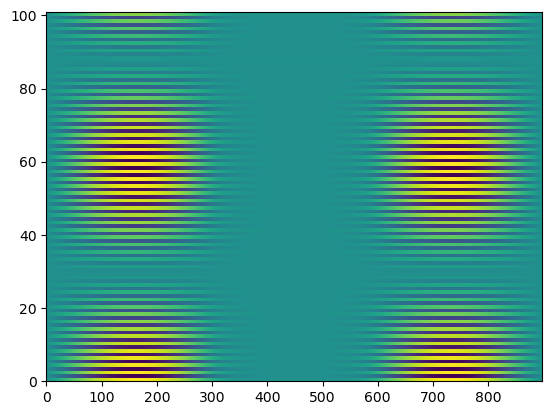

PyObject <matplotlib.collections.QuadMesh object at 0x7fa618b06a30>

In [24]:
plt.pcolormesh(real(psi))

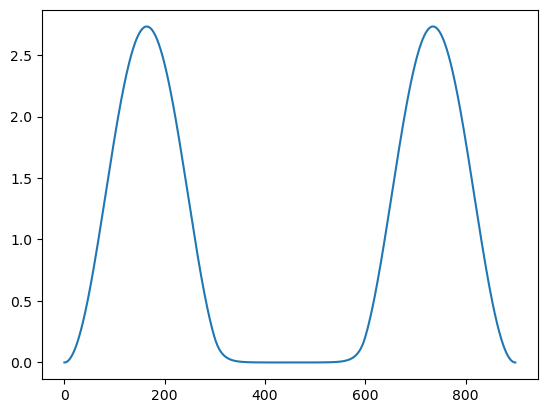

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa63b90c5e0>

In [17]:
# Lets just plot the ground state
plt.plot(abs2.(vectors[:, 1]))

In [18]:
t_space.step

1

In [19]:
t_space

0:1:100

In [324]:
N_third, N, dx = setup(200)
H = hamiltonian(N_third, 0)
dt = 0.0001
t_end = 0.1
t_space = 0:dt:t_end

psi = Array{Complex, 2}(undef, length(t_space), N-2)  # N-2 because endpoints are not used with H
#psi[1, :] = zeros(N-2)
#psi[1, Integer(N/2)] = 1/sqrt(dx)
x = range(0, 1, length=N-2)
psi[1, :] = exp.(-(x.-0.5).^2/0.01)

for i in eachindex(t_space)[2:end]
    psi[i, :] = crank_nicolson_step(psi[i-1, :], H, dt)
end

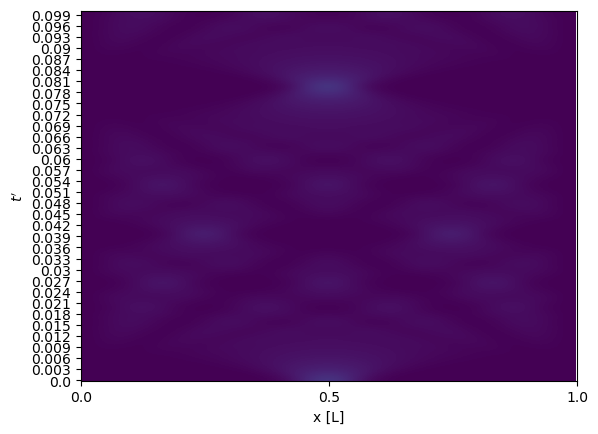

PyObject Text(25.900000000000006, 0.5, "$t'$")

In [326]:
plt.pcolormesh(abs2.(psi), vmax=7)
plt.yticks(1:30:length(t_space), t_space[1:30:end])
plt.xticks([0, N/2, N], [0, 0.5, 1])
plt.xlabel("x [L]")
plt.ylabel("\$t'\$")

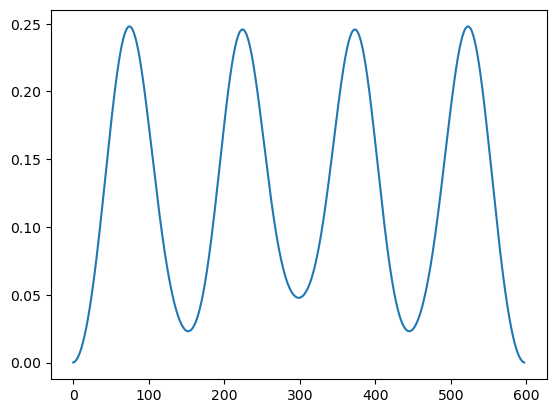

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7feb348225e0>

In [330]:
plt.plot(abs2.(psi[end, :]))